# **Exercise: Accelerating Jacobi's Method for Eigenvalue Computation**

Jacobi's method iteratively reduces off-diagonal elements of a symmetric matrix to zero. However, due to numerical effects, previously eliminated off-diagonal elements may reappear, requiring many iterations for full convergence.

To accelerate convergence, we first reduce the matrix to tridiagonal form before applying Jacobi's method. This reduction preserves certain off-diagonal zeros throughout the iterations, improving efficiency.

## **Tasks**

### (i) Implement Tridiagonal Reduction
- Write a Python script that first reduces a given symmetric matrix to tridiagonal form before applying Jacobi's method. Consider implementing Householder reduction.
- Verify that your script correctly maintains the structure of a tridiagonal matrix throughout the iterations.

### (ii) Compare Performance Using Iteration Count
Instead of measuring execution time, compare the **number of iterations required for convergence**, as this provides a more reliable efficiency metric.

1. Implement both:
   - The **standard Jacobi method**.
   - The **tridiagonalized Jacobi method** (applying tridiagonal reduction first).
2. Set the convergence criterion discussed in class (Jacobi's notes, *Section 2.2.3*)

3. Generate a sequence of random symmetric matrices of size $N \times N$ and test both scripts. Count the number of iterations required for each method to meet the convergence criteria.

   ```python
   import numpy as np

   def generate_symmetric_matrix(N):
       A = np.random.rand(N, N)
       return (A + A.T) / 2  # Ensure symmetry

   N_values = [4, 8, 16, 32, 64, 128, 256, ...]
   matrices = [generate_symmetric_matrix(N) for N in N_values]
   ```

### (iii) Analyze and Discuss Results
- Compare how the number of iterations scales with $N$.
- Does tridiagonal reduction significantly speed up convergence?
- How does the efficiency improvement change for large matrices?
- Verify eigenvalues using `numpy.linalg.eigh()`.
- Extend the analysis by plotting the decay of the sum of squared off-diagonal elements over iterations.

## **Implementation**
First , we define two auxiliary methods under the same class: the computation of a housegolder matrix given a vector $u$ and the transformation to upper hessenberg form of a square matrix $A$. These two will be used to implement the optimized version of the Jacobi Method.

In [50]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: " {0:0.3f}".format(x) if x > 0 else "{0:0.3f}".format(x)})

class MatrixTrasformations():
    @staticmethod
    def householder(u):
        """Construct the householder matrix given a vector u: nx1"""
        n = u.shape[0]
        u = u/np.linalg.norm(u)
        return np.eye(n) - 2*np.outer(u, u)

    @staticmethod
    def to_upper_hessenberg(A: np.ndarray) -> np.ndarray:
        """Transforms a matrix into upper Hessenberg form through Householder reflexions"""
        T = A.copy().astype(float)
        n = A.shape[0]
        for i in range(n-2):
            x = T[i+1:, i]
            Hx = np.zeros(n-i-1) 
            Hx[0] = -np.sign(x[0]) * np.linalg.norm(x)
            H = MatrixTrasformations.householder(x-Hx)
            
            T[i+1:, :] = H @ T[i+1:, :]
            T[:, i+1:] = T[:, i+1:] @ H
        return T

# Create an alias for MatrixTrasformations class
mt = MatrixTrasformations

We can verify that both methods above works by computing the upper hessenberg form of a random matrix. 

In [51]:
A = np.random.rand(4, 4)
print(A) 
print(mt.to_upper_hessenberg(A))

[[ 0.992  0.212  0.763  0.911]
 [ 0.873  0.149  0.957  0.507]
 [ 0.769  0.707  0.740  0.047]
 [ 0.631  0.668  0.014  0.160]]
[[ 0.992 -1.018  0.168  0.627]
 [-1.324  1.375  0.347 -0.077]
 [-0.000  0.178  0.378 -0.156]
 [-0.000 -0.000  0.078 -0.704]]


Now, using the auxiliary functions defined above, we can implement the standard Jacobi Method and our improved version by applying a tridiagonalization beforehand. 

In [52]:
class JacobiMethod():
    @classmethod
    def sum(cls, D, n):
        return np.sqrt(np.sum(np.diag(D)**2)/n)

    @classmethod
    def solve(cls, A: np.ndarray, tol=10e-4):
        """
        Jacobi method for finding eigenvalues and eigenvectors of a matrix A.
        """
        # Initialize V, D, and parameters:
        n = A.shape[0]
        D = A.copy().astype(float)
        V = np.eye(n)

        # Calculate row p and column q of the off-diagonal element of greatest magnitude in D:
        it = 1
        matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
        p, q = np.unravel_index(np.argmax(matrix), matrix.shape)
        while np.abs(D[p, q]) > tol*cls.sum(D, n):
            # Compute rotation parameters
            beta = (D[q, q] - D[p, p]) / (2 * D[p, q])
            t = np.sign(beta) / (np.abs(beta) + np.sqrt(beta**2 + 1))
            c = 1 / np.sqrt(1 + t**2)
            s = c * t
            R = np.array([[c, s], [-s, c]])

            # Zero out D_pq and D_qp and update V
            D[[p, q], :] = R.T @ D[[p, q], :]
            D[:, [p, q]] = D[:, [p, q]] @ R
            V[:, [p, q]] = V[:, [p, q]] @ R

            # Update row p and column q of the off-diagonal element of greatest magnitude in D for the next iteration:
            it += 1
            matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
            p, q = np.unravel_index(np.argmax(matrix), matrix.shape)

        return np.diag(D), V, it

class ImprovedJacobiMethod():
    @classmethod
    def solve(cls, A: np.ndarray, tol=10e-4):
        A = mt.to_upper_hessenberg(A)
        return JacobiMethod.solve(A, tol)


### Verify results

Let's verify that the implemented methods work as expected (compared to `numpy.linalg.eig()`)

In [53]:
def generate_symmetric_matrix(N):
    A = np.random.rand(N, N)
    return (A + A.T) / 2

A = generate_symmetric_matrix(10)
print(f"Eigenvalues (Jacobi Method): \t\t{np.sort(JacobiMethod.solve(A)[0])}")
print(f"Eigenvalues (Improved Jacobi Method): \t{np.sort(ImprovedJacobiMethod.solve(A)[0])}")
print(f"Eigenvalues (Numpy): \t\t\t{np.sort(np.linalg.eig(A)[0])}")

Eigenvalues (Jacobi Method): 		[-0.841 -0.611 -0.538 -0.278 -0.219  0.190  0.348  0.571  1.075  4.465]
Eigenvalues (Improved Jacobi Method): 	[-0.841 -0.611 -0.538 -0.278 -0.219  0.190  0.348  0.571  1.075  4.465]
Eigenvalues (Numpy): 			[-0.841 -0.611 -0.538 -0.278 -0.219  0.190  0.348  0.571  1.075  4.465]


### Performance Comparison

We generate a sample of symmetric matrices of different sizes from $N=4, \ldots, 128$ and compare the efficiency from each algorithm using those matrices and different tolerance values.

In [ ]:
N_values = [4, 8, 16, 32, 64, 96, 128] #, 256]
matrices = [generate_symmetric_matrix(N) for N in N_values]

jm_results = []
tjm_results = []
tols = [1e-3, 1e-4, 1e-5, 1e-6]
for i in range(len(tols)):
    jm_results.append([])
    tjm_results.append([])
    for n, A in zip(N_values, matrices):
        jm_results[i].append(JacobiMethod.solve(A, tols[i])[2])
        tjm_results[i].append(ImprovedJacobiMethod.solve(A, tols[i])[2])

As a result, for different values of tolerance, we have the following results that we can plot on a graph. 

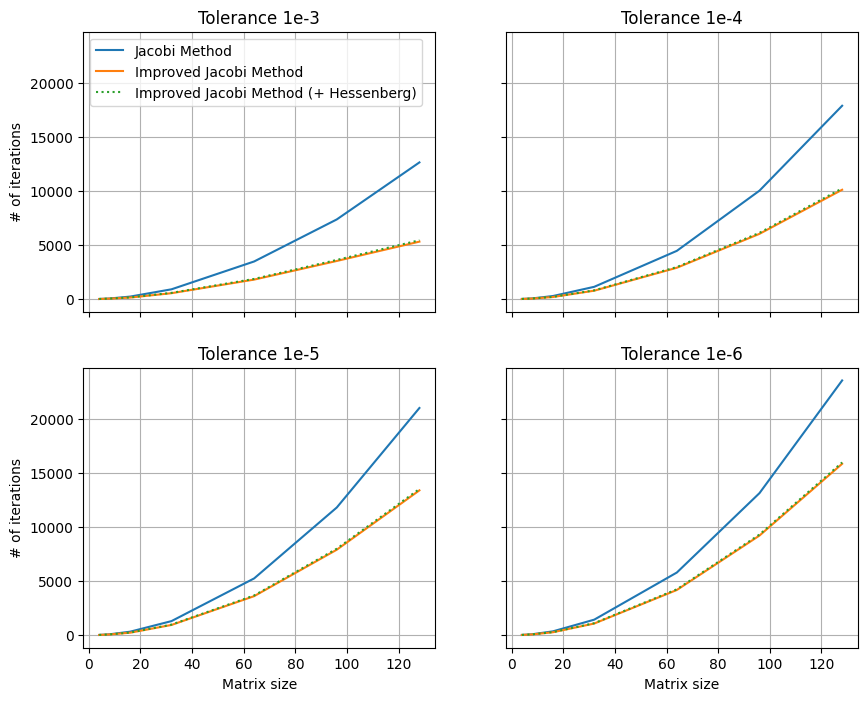

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 8), sharex=True, sharey=True)
titles = [
    'Tolerance 1e-3',
    'Tolerance 1e-4',
    'Tolerance 1e-5',
    'Tolerance 1e-6'
]
for i in range(len(tols)):
    axs[int(i/2), i%2].plot(N_values, jm_results[i], '-', label='Jacobi Method')
    axs[int(i/2), i%2].plot(N_values, tjm_results[i], '-', label='Improved Jacobi Method')
    axs[int(i/2), i%2].plot(N_values, [k+j-2 for k, j in zip(tjm_results[i], N_values)], ':', label='Improved Jacobi Method (+ Hessenberg)')
    axs[int(i/2), i%2].set_title(titles[i])

axs[0, 0].legend(loc='upper left')
for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='Matrix size', ylabel='# of iterations')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

We can see that the convergence time of both Jacobi Method grows in polynomial time with respect of the matrix size, and indeed, our improved version is faster. Moreover, the improved version is more optimal the bigger the matrix. However, the speed-up ratio decreases the smaller the chosen tolerance is. We can see it more clearly on the tables below.

In [ ]:
import pandas as pd

# Plot the speed up rate
print(f"Average speed-up rate for each tolerance")
for tol, jm, tjm in zip(tols, jm_results, tjm_results):
    ratios = [i/j for i, j in zip(jm, tjm)]
    print(f"Tol={tol}:\t {np.mean(ratios):.3f}x")

data = {}
print(f"\nSpeed-up rate for each matrix size")
data["N"] = N_values
for tol, jm, tjm in zip(tols, jm_results, tjm_results):
    data[str(tol)] = [i/j for i, j in zip(jm, tjm)]

df = pd.DataFrame(data)
print(df)

Average speed-up rate for each tolerance
Tol=0.001:	 1.730x
Tol=0.0001:	 1.451x
Tol=1e-05:	 1.363x
Tol=1e-06:	 1.310x

Speed-up rate for each matrix size
     N     0.001    0.0001     1e-05     1e-06
0    4  1.200000  1.000000  1.000000  1.000000
1    8  1.222222  1.254902  1.216667  1.218750
2   16  1.629371  1.471503  1.427928  1.319392
3   32  1.658135  1.460847  1.378723  1.334267
4   64  1.929679  1.538726  1.455503  1.386935
5   96  2.089185  1.661979  1.494625  1.426356
6  128  2.378546  1.768342  1.569074  1.486762


From these data, we can conclude that our improved Jacobi Method works best for matrices of large size (above $N = 50$) for an adequate tolerance.

## Does the Improved Jacobi Method preserve of the tridiagonal structure? 

In the statement, it was mentioned that once a tridiagonalization is performed, the matrix would preserve the tridiagonal form for each iteration of the Jacobi Method, but this is not true. The proof is left as an exercise for the reader. 

For curiosity, I tried to preserve the tridiagonal form by applying a tridiagonalization for each iteration. However, this does not work for two reasons:

1. Most of the time, the transformation to tridiagonal form undoes the previously applied rotation. 

2. The norm of the off-diagonal elements of a matrix always increases when applying the tridiagonal transformation for each iteration of Jacobi's Method. This means that applying the transformation will slow down the algorithm by increasing the number of iterations needed for the matrix to converge. 

To illustrate this, we will plot the difference between the frobenius norms of all the off-diagonal elements of the matrix: after the tridiagonal transformation and before it; for each iteration of the Jacobi Method. 

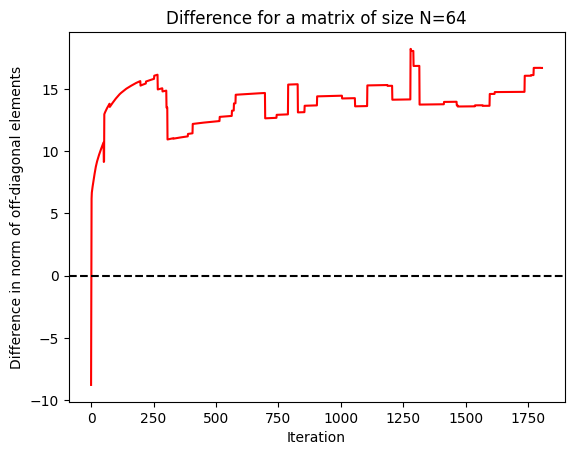

In [ ]:
class TestTriJacobiMethod(JacobiMethod):
    @classmethod
    def solve(cls, A: np.ndarray, tol=10e-4):
        """
        Jacobi method for finding eigenvalues and eigenvectors of a matrix A.
        """
        # Initialize V, D, and parameters:
        n = A.shape[0]
        D = mt.to_upper_hessenberg(A)
        V = np.eye(n)

        # Calculate row p and column q of the off-diagonal element of greatest magnitude in D:
        it = 1
        AMatrix = np.tril(np.abs(A - np.diag(np.diag(A))),-1)
        matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
        p, q = np.unravel_index(np.argmax(matrix), matrix.shape)
        norm_diffs = [np.linalg.norm(matrix) - np.linalg.norm(AMatrix)]
        while np.abs(D[p, q]) > tol*cls.sum(D, n):
            # Compute rotation parameters
            beta = (D[q, q] - D[p, p]) / (2 * D[p, q])
            t = np.sign(beta) / (np.abs(beta) + np.sqrt(beta**2 + 1))
            c = 1 / np.sqrt(1 + t**2)
            s = c * t
            R = np.array([[c, s], [-s, c]])

            # Zero out D_pq and D_qp and update V
            D[[p, q], :] = R.T @ D[[p, q], :]
            D[:, [p, q]] = D[:, [p, q]] @ R
            V[:, [p, q]] = V[:, [p, q]] @ R

            # We compute the difference between the norm of off-diagonal elements of D and D' := D after tridiagonal transformation:
            triD = mt.to_upper_hessenberg(D)
            triMatrix = np.tril(np.abs(triD - np.diag(np.diag(triD))),-1)
            norm_diffs.append(np.linalg.norm(triMatrix) - np.linalg.norm(matrix))

            # Update row p and column q of the off-diagonal element of greatest magnitude in D for the next iteration:
            it += 1
            matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
            p, q = np.unravel_index(np.argmax(matrix), matrix.shape)

        return np.diag(D), V, norm_diffs, it
    

results = TestTriJacobiMethod.solve(matrices[4])
plt.plot(results[2], label='Norm Difference', color='red')
plt.axline((0, 0), linestyle='dashed', slope=0, color='black')
plt.xlabel('Iteration')
plt.ylabel('Difference in norm of off-diagonal elements')
plt.title('Difference for a matrix of size N=64')
plt.show()

Indeed, there is no point throughout the algorithm in which applying the tridiagonal transformation improves the efficiency of Jacobi Method. The first iteration is the only time where the tridiagonalization would improve the efficiency of algorithm. This is the reason why applying tridiagonalization improves the execution time.

#### Evolution of the norm of off-diagonal elements

Now that we understand why Householder reduction improves the Jacobi Method, we can visualize how the frobenius norm of the off-diagonal elements progress throughout each iteration of the Jacobi-Method.

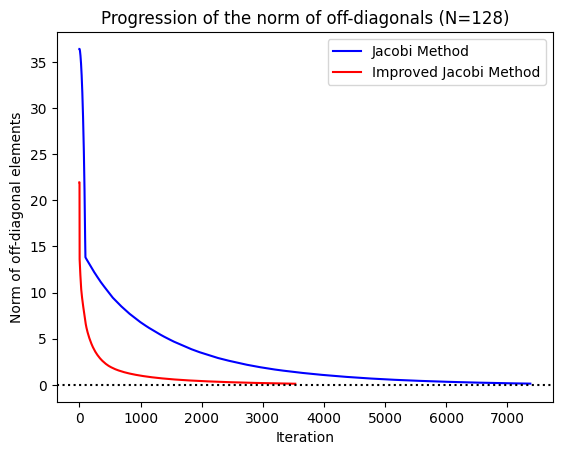

In [ ]:
class TestJacobiMethod(JacobiMethod):
    @classmethod
    def solve(cls, A: np.ndarray, tol=10e-4):
        """
        Jacobi method for finding eigenvalues and eigenvectors of a matrix A.
        """
        # Initialize V, D, and parameters:
        n = A.shape[0]
        D = A.copy().astype(float)
        V = np.eye(n)

        # Calculate row p and column q of the off-diagonal element of greatest magnitude in D:
        it = 1
        matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
        p, q = np.unravel_index(np.argmax(matrix), matrix.shape)
        norms = [np.linalg.norm(matrix)]
        while np.abs(D[p, q]) > tol*cls.sum(D, n):
            # Compute rotation parameters
            beta = (D[q, q] - D[p, p]) / (2 * D[p, q])
            t = np.sign(beta) / (np.abs(beta) + np.sqrt(beta**2 + 1))
            c = 1 / np.sqrt(1 + t**2)
            s = c * t
            R = np.array([[c, s], [-s, c]])

            # Zero out D_pq and D_qp and update V
            D[[p, q], :] = R.T @ D[[p, q], :]
            D[:, [p, q]] = D[:, [p, q]] @ R
            V[:, [p, q]] = V[:, [p, q]] @ R

            # We compute the difference between the norm of off-diagonal elements of D and D' := D after tridiagonal transformation:
            norms.append(np.linalg.norm(matrix))

            # Update row p and column q of the off-diagonal element of greatest magnitude in D for the next iteration:
            it += 1
            matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
            p, q = np.unravel_index(np.argmax(matrix), matrix.shape)

        return np.diag(D), V, norms, it
    
class TestTriJacobiMethod():
    @classmethod
    def solve(cls, A: np.ndarray, tol=10e-4):
        A = mt.to_upper_hessenberg(A)
        return TestJacobiMethod.solve(A, tol)
    
results1 = TestJacobiMethod.solve(matrices[5])
results2 = TestTriJacobiMethod.solve(matrices[5])
plt.plot(results1[2], label='Jacobi Method', color='blue')
plt.plot(results2[2], label='Improved Jacobi Method', color='red')
plt.axline((0, 0), linestyle='dotted', slope=0, color='black')
plt.xlabel('Iteration')
plt.ylabel('Norm of off-diagonal elements')
plt.title('Progression of the norm of off-diagonals (N=128)')
plt.legend()
plt.show()

#### Heatmap of targetted elements

Another way to see how applying Householder reduction improves the Jacobi Method is to visualize which elements of the matrix are rotated.


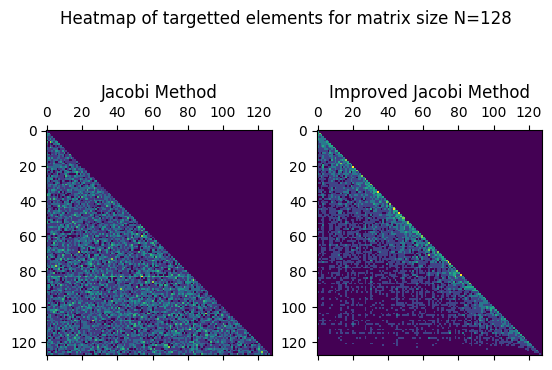

In [ ]:
class TestJacobiMethod(JacobiMethod):
    @classmethod
    def solve(cls, A: np.ndarray, tol=10e-4):
        """
        Jacobi method for finding eigenvalues and eigenvectors of a matrix A.
        """
        # Initialize V, D, and parameters:
        n = A.shape[0]
        D = A.copy().astype(float)
        V = np.eye(n)

        # Calculate row p and column q of the off-diagonal element of greatest magnitude in D:
        matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
        p, q = np.unravel_index(np.argmax(matrix), matrix.shape)
        its = [(p, q)]
        while np.abs(D[p, q]) > tol*cls.sum(D, n):
            # Compute rotation parameters
            beta = (D[q, q] - D[p, p]) / (2 * D[p, q])
            t = np.sign(beta) / (np.abs(beta) + np.sqrt(beta**2 + 1))
            c = 1 / np.sqrt(1 + t**2)
            s = c * t
            R = np.array([[c, s], [-s, c]])

            # Zero out D_pq and D_qp and update V
            D[[p, q], :] = R.T @ D[[p, q], :]
            D[:, [p, q]] = D[:, [p, q]] @ R
            V[:, [p, q]] = V[:, [p, q]] @ R

            # Update row p and column q of the off-diagonal element of greatest magnitude in D for the next iteration:
            its.append((p, q))
            matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
            p, q = np.unravel_index(np.argmax(matrix), matrix.shape)

        return np.diag(D), V, its
    
class TestTriJacobiMethod():
    @classmethod
    def solve(cls, A: np.ndarray, tol=10e-4):
        A = mt.to_upper_hessenberg(A)
        return TestJacobiMethod.solve(A, tol)


heatmap1 = np.zeros((N_values[-1], N_values[-1]))
for coords in TestJacobiMethod.solve(matrices[-1])[2]:
    heatmap1[coords[0], coords[1]] += 1

heatmap2 = np.zeros((N_values[-1], N_values[-1]))
for coords in TestTriJacobiMethod.solve(matrices[-1])[2]:
    heatmap2[coords[0], coords[1]] += 1

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]})
axs[0].matshow(heatmap1)
axs[0].set_title("Jacobi Method")
axs[1].matshow(heatmap2)
axs[1].set_title("Improved Jacobi Method")
fig.suptitle("Heatmap of targetted elements for matrix size N=128")
plt.show()

The rotations of the Improved Jacobi Method are concetrated around the diagonal, while the classical version is more scattered.